In [28]:
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, median_absolute_error
import math
from sklearn.metrics import mean_absolute_error

In [31]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
PVR = pd.read_csv("E:/PVR.NS.csv", index_col='Date', parse_dates=['Date'])
PVR.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-10-12,832.000000,839.950012,815.000000,823.400024,815.866699,76889
2015-10-13,811.599976,838.000000,811.599976,829.950012,822.356812,88390
2015-10-14,834.950012,842.000000,827.150024,838.299988,830.630249,62646
2015-10-15,841.650024,851.950012,837.400024,849.200012,841.430603,57628
2015-10-16,851.000000,875.000000,850.250000,853.000000,845.195801,516982


In [32]:
PVR.isna().any()

Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

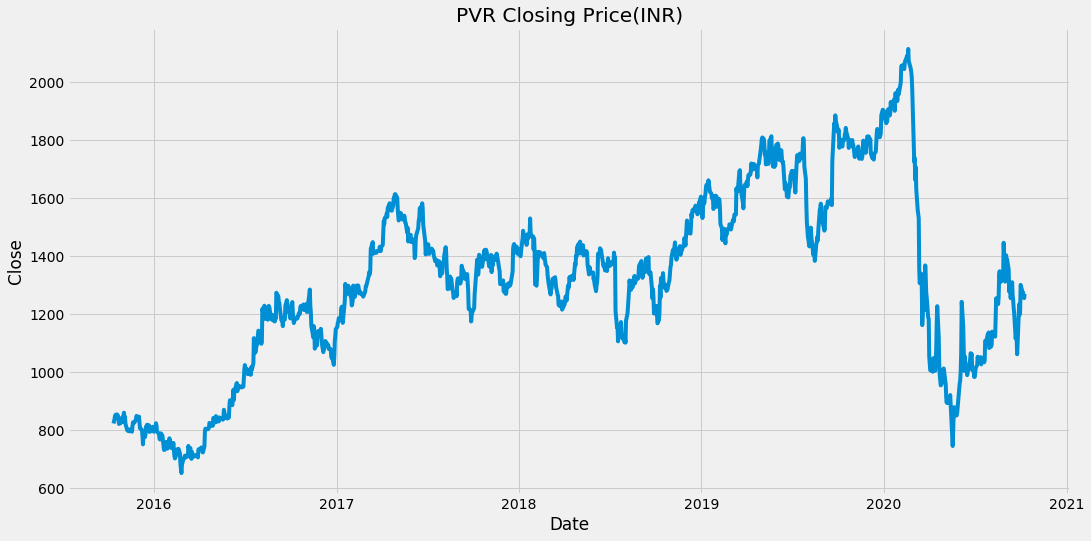

In [33]:
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close')
plt.plot(PVR['Close'])
plt.title('PVR Closing Price(INR)')
plt.show()

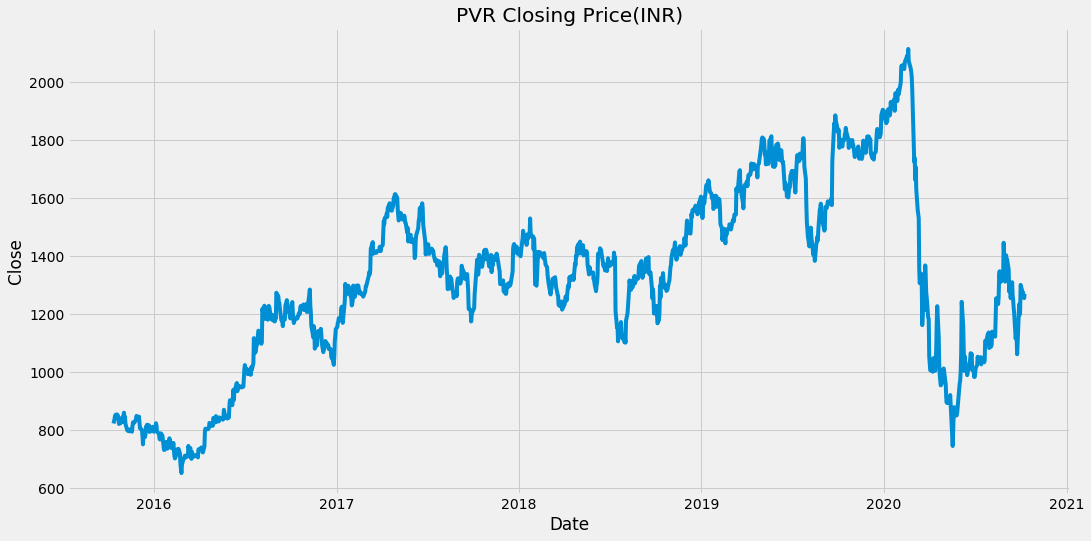

In [34]:
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close')
plt.plot(PVR['Close'])
plt.title('PVR Closing Price(INR)')
plt.show()

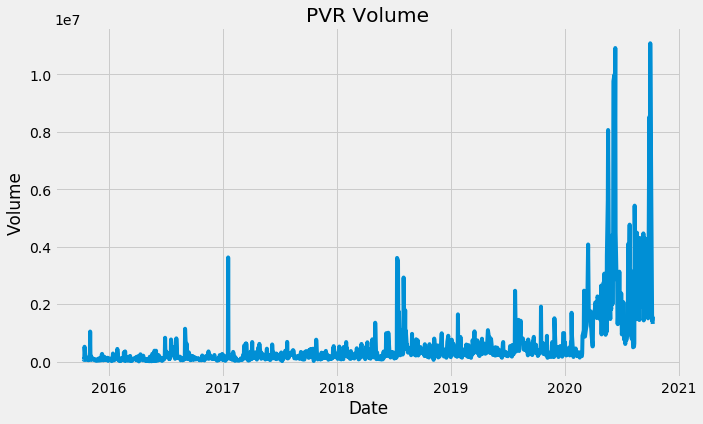

In [35]:
plt.xlabel('Date')
plt.ylabel('Volume')
plt.plot(PVR['Volume'])
plt.title('PVR Volume')
plt.show()

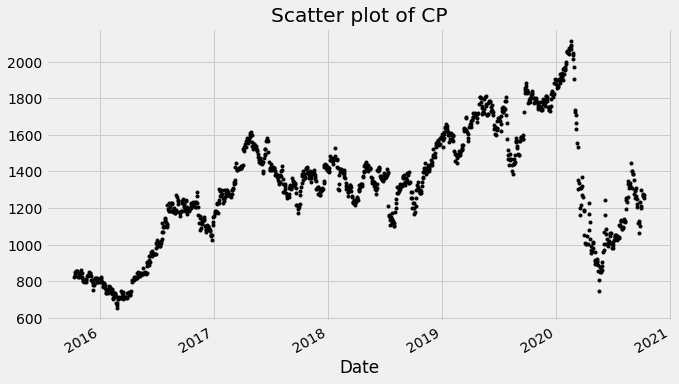

In [36]:
dt_close = PVR['Close']
dt_close.plot(style='k.')
plt.title('Scatter plot of CP')
plt.show()

In [37]:
def test_stationarity(timeseries):
    rolmean  = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print('Results of fuller test')
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key,values in adft[4].items():
        output['Critical value (%s)'%key] = values
    print(output)

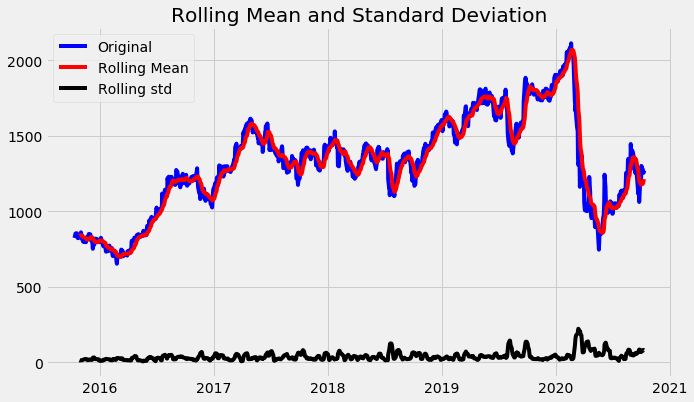

Results of fuller test
Test Statistics                  -2.344567
p-value                           0.157997
No. of lags used                 10.000000
Number of observations used    1219.000000
Critical value (1%)              -3.435726
Critical value (5%)              -2.863914
Critical value (10%)             -2.568034
dtype: float64


<Figure size 720x432 with 0 Axes>

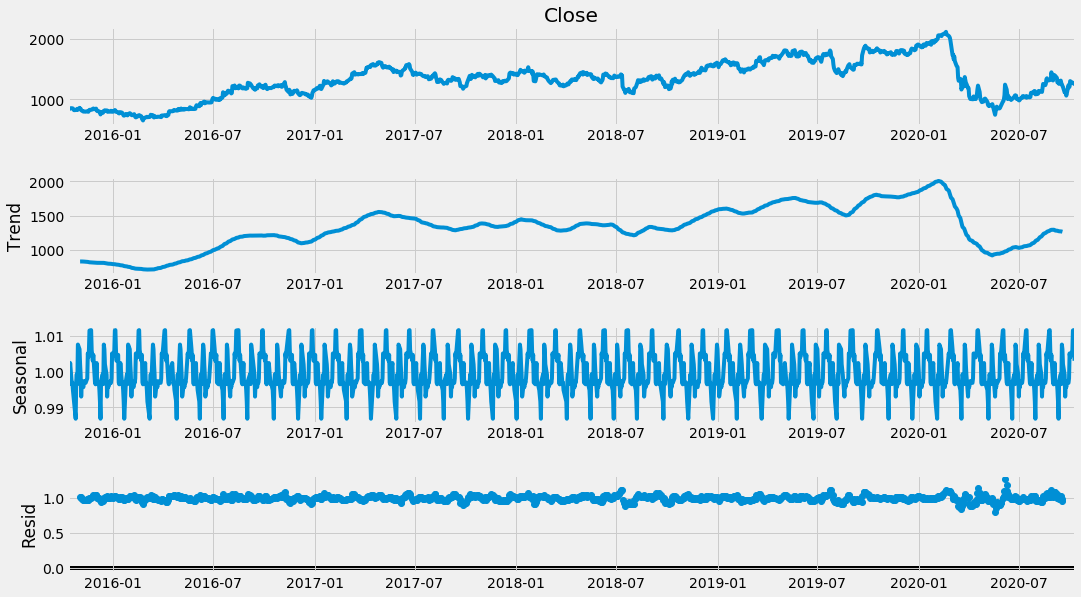

In [38]:
test_stationarity(dt_close)
result = seasonal_decompose(dt_close, model='multiplicative', freq = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)
plt.show()

No handles with labels found to put in legend.


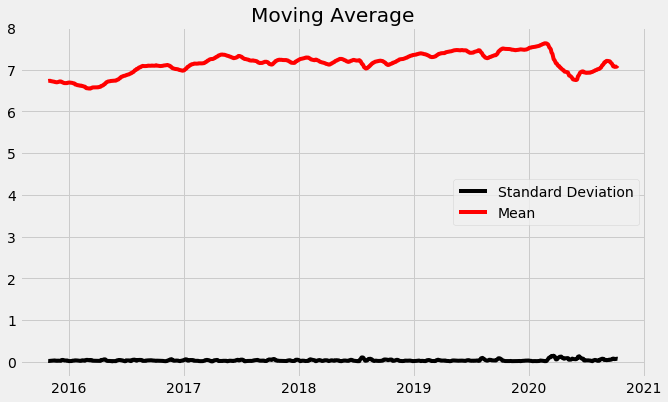

In [39]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
dt_log = np.log(dt_close)
moving_avg = dt_log.rolling(12).mean()
std_dev = dt_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color='black', label = "Standard Deviation")
plt.plot(moving_avg, color='red', label = "Mean")
plt.legend()
plt.show()

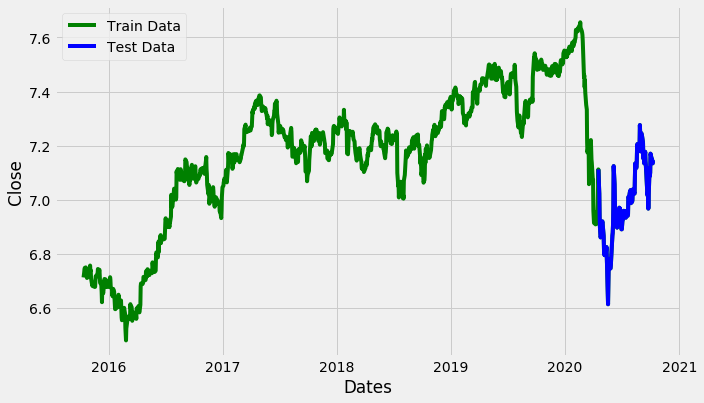

In [40]:
train_data, test_data = dt_log[3:int(len(dt_log)*0.9)], dt_log[int(len(dt_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close')
plt.plot(dt_log, 'green', label='Train Data')
plt.plot(test_data, 'blue', label='Test Data')
plt.legend()
plt.show()

In [41]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                             test='adf',
                             max_p=3, max_q=3,
                             m=1,
                             d=None,
                             seasonal=False,
                             start_P=0,
                             D=0,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)
print(model_autoARIMA.summary())

Fit ARIMA: order=(0, 1, 0); AIC=-5302.723, BIC=-5292.712, Fit time=0.005 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-5300.868, BIC=-5285.850, Fit time=0.046 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-5300.851, BIC=-5285.834, Fit time=0.023 seconds
Fit ARIMA: order=(1, 1, 1); AIC=-5300.944, BIC=-5280.921, Fit time=0.159 seconds
Total fit time: 0.243 seconds
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1103
Model:                 ARIMA(0, 1, 0)   Log Likelihood                2653.362
Method:                           css   S.D. of innovations              0.022
Date:                Tue, 13 Oct 2020   AIC                          -5302.723
Time:                        22:07:00   BIC                          -5292.712
Sample:                             1   HQIC                         -5298.936
                                                                              
              

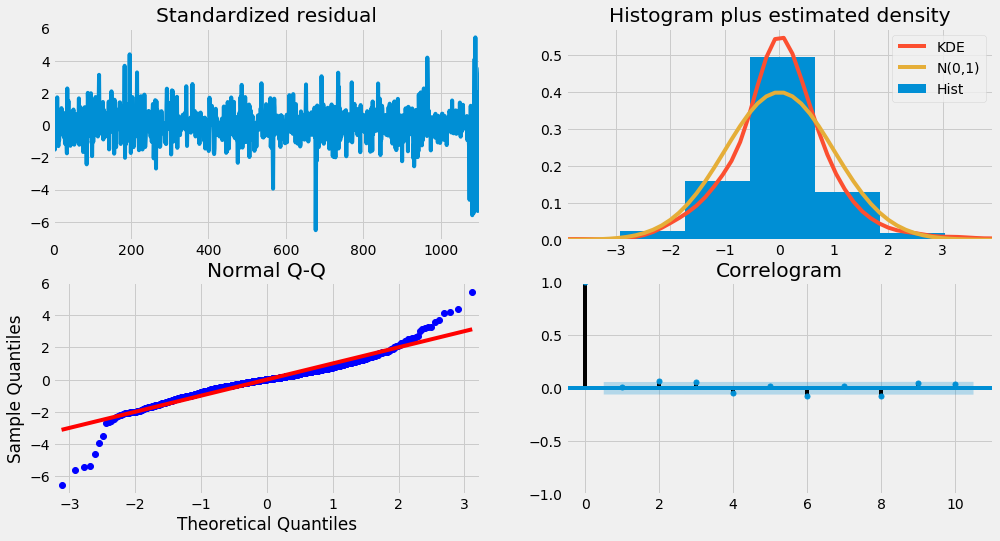

In [42]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [43]:
model = ARIMA(train_data, order=(3,1,2))
fitted = model.fit(disp=-1)
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1103
Model:                 ARIMA(3, 1, 2)   Log Likelihood                2663.684
Method:                       css-mle   S.D. of innovations              0.022
Date:                Tue, 13 Oct 2020   AIC                          -5313.369
Time:                        22:07:02   BIC                          -5278.328
Sample:                             1   HQIC                         -5300.114
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.001      0.413      0.680      -0.001       0.002
ar.L1.D.Close    -0.9051      0.288     -3.142      0.002      -1.470      -0.340
ar.L2.D.Close     0.0143      0.268     

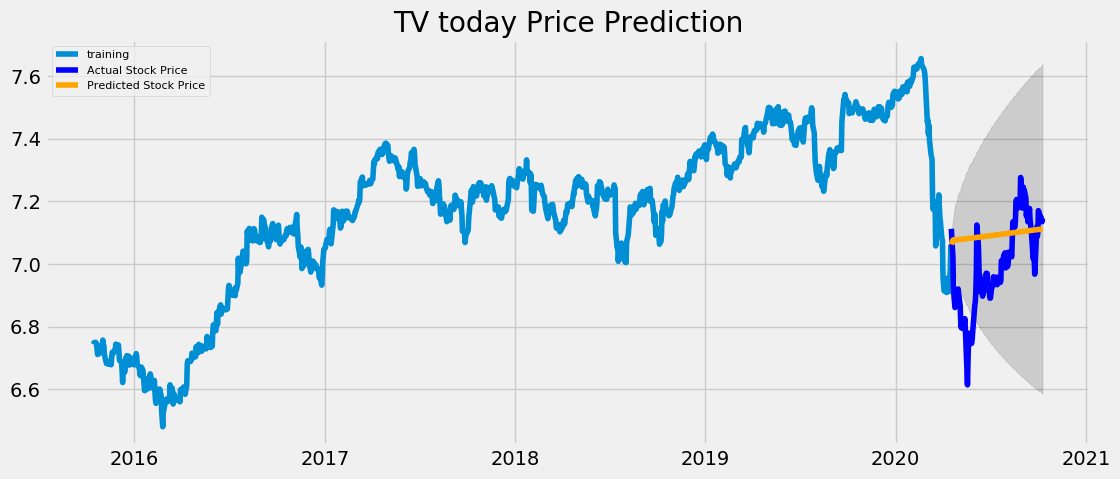

In [44]:
fc, se, conf = fitted.forecast(123, alpha=0.05)
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('TV today Price Prediction')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [45]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

In [46]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    me = np.mean(forecast - actual)
    mae = np.mean(np.abs(forecast - actual))
    mpe = np.mean((forecast - actual)/actual)
    rmse = np.mean((forecast - actual)**2)**.5
    corr = np.corrcoef(forecast, actual)[0,1]
    mins = np.amin(np.hstack([forecast[:,None],
                             actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
                             actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)
    acf1 = acf(fc-test_data)[1]
    return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'rmse': rmse, 'acf1': acf1, 'corr': corr, 'minmax': minmax})
forecast_accuracy(fc, test_data.values)

{'mape': 0.019827144662605895,
 'me': 0.09999322254352473,
 'mae': 0.13704915441568977,
 'mpe': 0.014676950429060571,
 'rmse': 0.16482845453959658,
 'acf1': 0.9436094668606396,
 'corr': 0.7600878406786286,
 'minmax': 0.019300602965611424}

In [47]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

In [48]:
df = pd.read_csv("E:\PVR.NS.csv", header=0)

model = pm.auto_arima(df.Close, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Fit ARIMA: order=(1, 1, 1); AIC=11920.325, BIC=11940.781, Fit time=0.173 seconds
Fit ARIMA: order=(0, 1, 0); AIC=11919.528, BIC=11929.756, Fit time=0.000 seconds
Fit ARIMA: order=(1, 1, 0); AIC=11920.569, BIC=11935.911, Fit time=0.031 seconds
Fit ARIMA: order=(0, 1, 1); AIC=11920.661, BIC=11936.003, Fit time=0.016 seconds
Total fit time: 0.244 seconds
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1229
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -5957.764
Method:                           css   S.D. of innovations             30.837
Date:                Tue, 13 Oct 2020   AIC                          11919.528
Time:                        22:07:10   BIC                          11929.756
Sample:                             1   HQIC                         11923.376
                                                                              
              

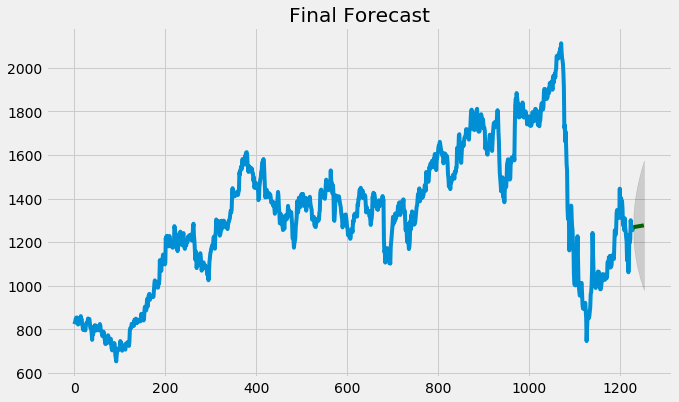

In [49]:
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.Close), len(df.Close)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.Close)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast")
plt.show()

In [50]:
fc_series

1230    1268.762107
1231    1269.124190
1232    1269.486273
1233    1269.848356
1234    1270.210439
1235    1270.572522
1236    1270.934605
1237    1271.296688
1238    1271.658771
1239    1272.020854
1240    1272.382937
1241    1272.745020
1242    1273.107103
1243    1273.469186
1244    1273.831269
1245    1274.193352
1246    1274.555435
1247    1274.917518
1248    1275.279601
1249    1275.641684
1250    1276.003767
1251    1276.365850
1252    1276.727933
1253    1277.090016
dtype: float64

Technical Analysis

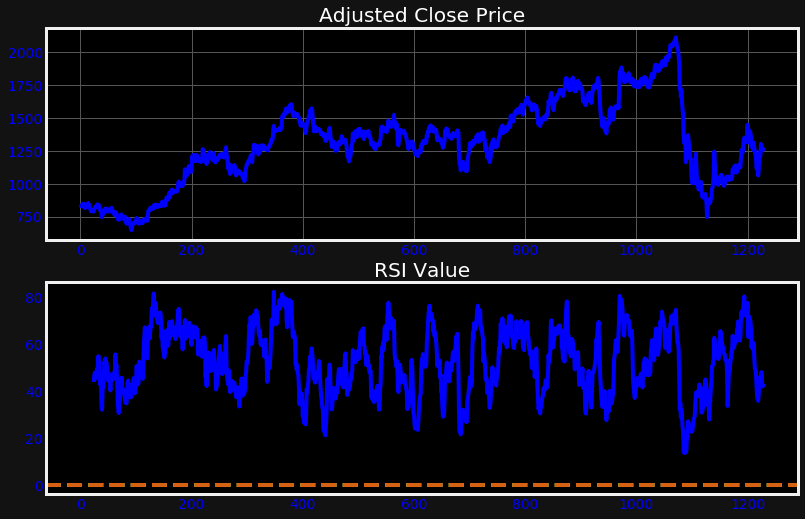

In [22]:
import datetime as dt

data = pd.read_csv("E:/PVR.NS.csv")

tv = data["Adj Close"].diff(1)
tv.dropna(inplace=True)

positive = tv.copy()
negative = tv.copy()

positive[positive < 0] = 0
negative[negative > 0] = 0

days = 24

average_gain = positive.rolling(window=days).mean()
average_loss = abs(negative.rolling(window=days).mean())

relative_strength = average_gain / average_loss
RSI = 100.0 - (100.0 / (1.0 + relative_strength))

combined = pd.DataFrame()
combined["Adj Close"] = data["Adj Close"]
combined['RSI'] = RSI

plt.figure(figsize=(12,8))
ax1 = plt.subplot(211)
ax1.plot(combined.index, combined["Adj Close"], color="blue")
ax1.set_title("Adjusted Close Price", color='white')

ax1.grid(True, color="#555555")
ax1.set_axisbelow(True)
ax1.set_facecolor('black')
ax1.figure.set_facecolor('#121212')
ax1.tick_params(axis='x', colors='blue')
ax1.tick_params(axis='y', colors='blue')

ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(combined.index, combined['RSI'], color='blue')
ax2.axhline(0, linestyle='--', alpha=0.5, color='#ff0000')
ax2.axhline(0, linestyle='--', alpha=0.5, color='#ffaa00')
ax2.axhline(0, linestyle='--', alpha=0.5, color='#00ff00')
ax2.axhline(0, linestyle='--', alpha=0.5, color='#cccccc')
ax2.axhline(0, linestyle='--', alpha=0.5, color='#cccccc')
ax2.axhline(0, linestyle='--', alpha=0.5, color='#00ff00')
ax2.axhline(0, linestyle='--', alpha=0.5, color='#ffaa00')
ax2.axhline(0, linestyle='--', alpha=0.5, color='#ff0000')

ax2.set_title("RSI Value", color='white')
ax2.grid(False)
ax2.set_axisbelow(True)
ax2.set_facecolor("black")
ax2.tick_params(axis='x', colors='blue')
ax2.tick_params(axis='y', colors='blue')

plt.show()